# Project 2: Recommender System

In [ ]:
#Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from proj2_helpers import *
%load_ext autoreload
%autoreload 2

## 1-Preprocessing

In [2]:
#Loading the training data
data=pd.read_csv('data_train.csv')
data.head()

,Id,Prediction
0,r44_c1,4
1,r61_c1,3
2,r67_c1,4
3,r72_c1,3
4,r86_c1,5


In [3]:
#Extracting row and column numbers
data['Id']=data['Id'].apply(lambda x: re.findall(r'\d+', str(x)))
data.head()

,Id,Prediction
0,"[44, 1]",4
1,"[61, 1]",3
2,"[67, 1]",4
3,"[72, 1]",3
4,"[86, 1]",5


In [4]:
#Row and column values to features
num_id_data=data
num_id_data[['Row', 'Col']]=pd.DataFrame(data.Id.values.tolist(), index= data.index)
num_id_data=num_id_data.drop(columns='Id')
num_id_data.head()

,Prediction,Row,Col
0,4,44,1
1,3,61,1
2,4,67,1
3,3,72,1
4,5,86,1


In [5]:
cli_vs_mov=num_id_data.pivot(index='Row', columns='Col', values='Prediction')
cli_vs_mov.head()

Col,1,10,100,1000,101,102,103,104,105,106,...,990,991,992,993,994,995,996,997,998,999
Row,,,,,,,,,,,,,,,,,,,,,
1,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,4.0,NaN,NaN
100,NaN,5.0,NaN,NaN,5.0,NaN,3.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1000,NaN,2.0,4.0,2.0,5.0,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,4.0,2.0,NaN,5.0,1.0,NaN,2.0,3.0
10000,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,2.0,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN


## 2-Helper Functions

In [176]:
def initialize_clusters(data, k):
    """initialize the k cluster centers (the means).
    input:
        data: original data with shape (num_sample, num_feature).
        k: predefined number of clusters for the k-means algorithm.
    output:
        a numpy array with shape (k, num_feature)
    """
    # ***************************************************************************************************
    # INSERT YOUR CODE HERE
    # TODO: initialize cluster centers.
    # TODO: Make sure you choose k clusters from the data itself,
    #       or ensure otherwise that your initializations have the same scaling as the data
    # ***************************************************************************************************
    random=np.random.rand(k,data.shape[1])
    min_data=np.nanmin(data,axis=0)
    max_data=np.nanmax(data,axis=0)
    return np.random.uniform(min_data,max_data,(k,data.shape[1]))

In [177]:
def build_distance_matrix(data, mu):
    """build a distance matrix.
    return
        distance matrix:
            row of the matrix represents the data point,
            column of the matrix represents the k-th cluster.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: build distance matrix
    # ***************************************************
    return np.array([np.nansum((data-mu[i])**2,axis=1) for i in range(len(mu))]).T

In [178]:
def update_kmeans_parameters(data, mu_old):
    """update the parameter of kmeans
    return:
        losses: loss of each data point with shape (num_samples, 1)
        assignments: assignments vector z with shape (num_samples, 1)
        mu: mean vector mu with shape (k, num_features)
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: update kmeans parameters
    # ***************************************************
    d=build_distance_matrix(data, mu_old)
    losses=np.min(d,1)
    assignments=np.argmin(d,1)
    mu=np.array([np.mean(data[assignments==i],0) for i in range(mu_old.shape[0])])
    mu=np.where(np.isnan(mu),mu_old,mu)
    return losses,assignments,mu

In [179]:
def kmeans(data, k, max_iters, threshold):
    """run the k-means algorithm."""
    output_figure = "kmeans_figures/"
    #Initialize the cluster.
    mu_old = initialize_clusters(data, k)
    average_loss=0
    #Start the kmeans algorithm.
    for iter in range(max_iters):
        #Update z and mu
        losses, assignments, mu = update_kmeans_parameters(data, mu_old)
        #Calculate the average loss over all points
        old_avg_loss=average_loss
        average_loss = np.mean(losses)
        print("The current iteration of k-means is: {i}, \
               the average loss is {l}.".format(i=iter, l=average_loss))
        #Check converge
        if iter > 0 and np.abs(average_loss - old_avg_loss) < threshold:
            break
        #Output plot
        #Plot(data, mu, mu_old, output_figure + "kmean_iter{i}".format(i=iter))
        #Update k-means information.
        mu_old = mu
    return assignments, mu, average_loss

In [180]:
#returns the most common value for each column of n
def most_common(x):
    top_freq=[]
    for i in range(x.shape[1]):
        temp=np.unique(x.iloc[:,i],return_counts=True)
        top_freq=np.append(top_freq,temp[0][temp[1].argmax()])
    return top_freq

## 3-Parameter Selection

For k= 1 :
The current iteration of k-means is: 0,                the average loss is 385.7680641185425.
The current iteration of k-means is: 1,                the average loss is 124.72241850996271.
The current iteration of k-means is: 2,                the average loss is 124.72241850996271.
For k= 2 :
The current iteration of k-means is: 0,                the average loss is 379.3810192390307.
The current iteration of k-means is: 1,                the average loss is 123.15840740377902.
The current iteration of k-means is: 2,                the average loss is 119.49095519942665.
The current iteration of k-means is: 3,                the average loss is 118.85519868493108.
The current iteration of k-means is: 4,                the average loss is 118.80975286317283.
The current iteration of k-means is: 5,                the average loss is 118.8039094488833.
The current iteration of k-means is: 6,                the average loss is 118.80279017278994.
The current iteration of k-mean

The current iteration of k-means is: 11,                the average loss is 114.55184203876607.
The current iteration of k-means is: 12,                the average loss is 114.53573644240517.
The current iteration of k-means is: 13,                the average loss is 114.52195394183502.
The current iteration of k-means is: 14,                the average loss is 114.51113683058378.
The current iteration of k-means is: 15,                the average loss is 114.50413031105506.
The current iteration of k-means is: 16,                the average loss is 114.50034585643111.
The current iteration of k-means is: 17,                the average loss is 114.4962245893175.
The current iteration of k-means is: 18,                the average loss is 114.49214867158162.
The current iteration of k-means is: 19,                the average loss is 114.48934524411554.
The current iteration of k-means is: 20,                the average loss is 114.48709385638828.
The current iteration of k-means is: 21, 

The current iteration of k-means is: 7,                the average loss is 113.06216243035533.
The current iteration of k-means is: 8,                the average loss is 112.9763805951931.
The current iteration of k-means is: 9,                the average loss is 112.92306175543463.
The current iteration of k-means is: 10,                the average loss is 112.88166431884375.
The current iteration of k-means is: 11,                the average loss is 112.85467420325035.
The current iteration of k-means is: 12,                the average loss is 112.83587807142679.
The current iteration of k-means is: 13,                the average loss is 112.81862440134412.
The current iteration of k-means is: 14,                the average loss is 112.80533443116308.
The current iteration of k-means is: 15,                the average loss is 112.79064704654441.
The current iteration of k-means is: 16,                the average loss is 112.77637430447945.
The current iteration of k-means is: 17,    

The current iteration of k-means is: 7,                the average loss is 111.69855818771902.
The current iteration of k-means is: 8,                the average loss is 111.627688541022.
The current iteration of k-means is: 9,                the average loss is 111.56553361154441.
The current iteration of k-means is: 10,                the average loss is 111.52681911443223.
The current iteration of k-means is: 11,                the average loss is 111.49978704077411.
The current iteration of k-means is: 12,                the average loss is 111.47918316813893.
The current iteration of k-means is: 13,                the average loss is 111.46488333809955.
The current iteration of k-means is: 14,                the average loss is 111.45356448376333.
The current iteration of k-means is: 15,                the average loss is 111.44473786856555.
The current iteration of k-means is: 16,                the average loss is 111.43641199907977.
The current iteration of k-means is: 17,     

The current iteration of k-means is: 24,                the average loss is 111.10266902899757.
The current iteration of k-means is: 25,                the average loss is 111.09843171169359.
The current iteration of k-means is: 26,                the average loss is 111.09483174715966.
The current iteration of k-means is: 27,                the average loss is 111.09118581451116.
The current iteration of k-means is: 28,                the average loss is 111.08667394864587.
The current iteration of k-means is: 29,                the average loss is 111.08262380648728.
The current iteration of k-means is: 30,                the average loss is 111.07916208810835.
The current iteration of k-means is: 31,                the average loss is 111.07743560976854.
The current iteration of k-means is: 32,                the average loss is 111.07350761206885.
The current iteration of k-means is: 33,                the average loss is 111.07071709848063.
The current iteration of k-means is: 34,

The current iteration of k-means is: 11,                the average loss is 110.31532449039801.
The current iteration of k-means is: 12,                the average loss is 110.2969344138432.
The current iteration of k-means is: 13,                the average loss is 110.28210747968582.
The current iteration of k-means is: 14,                the average loss is 110.27601638298701.
The current iteration of k-means is: 15,                the average loss is 110.26990140281625.
The current iteration of k-means is: 16,                the average loss is 110.26229504456762.
The current iteration of k-means is: 17,                the average loss is 110.2568023386958.
The current iteration of k-means is: 18,                the average loss is 110.24995169812208.
The current iteration of k-means is: 19,                the average loss is 110.24421785278591.
The current iteration of k-means is: 20,                the average loss is 110.24082529693271.
The current iteration of k-means is: 21,  

The current iteration of k-means is: 7,                the average loss is 110.247887526559.
The current iteration of k-means is: 8,                the average loss is 110.15141498558334.
The current iteration of k-means is: 9,                the average loss is 110.08577114746505.
The current iteration of k-means is: 10,                the average loss is 110.02519467810896.
The current iteration of k-means is: 11,                the average loss is 109.9784098907263.
The current iteration of k-means is: 12,                the average loss is 109.94124388726523.
The current iteration of k-means is: 13,                the average loss is 109.89678223756698.
The current iteration of k-means is: 14,                the average loss is 109.86826721281992.
The current iteration of k-means is: 15,                the average loss is 109.84936852164026.
The current iteration of k-means is: 16,                the average loss is 109.83250976400974.
The current iteration of k-means is: 17,      

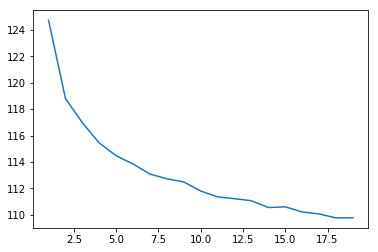

In [78]:
#Defining the parameters
k = 20
max_iters = 100
threshold = 1e-3
#Grid-searching the number of clusters (by 100s)
losses=[]
for i in range(1,k):
    print('For k=',i,':')
    losses.append(kmeans(cli_vs_mov, i, max_iters, threshold)[2])
plt.plot(range(1,k),losses)

In [194]:
#k chosen using the above plots
k_opt=9
#Defining the parameters
max_iters = 100
threshold = 1e-6
#Computing clusters of similar users
assignments, mu, _=kmeans(cli_vs_mov, k_opt, max_iters, threshold)

The current iteration of k-means is: 0,                the average loss is 338.2407241814187.
The current iteration of k-means is: 1,                the average loss is 120.31189821145902.
The current iteration of k-means is: 2,                the average loss is 115.15645933244026.
The current iteration of k-means is: 3,                the average loss is 113.68345749307282.
The current iteration of k-means is: 4,                the average loss is 113.16677041238654.
The current iteration of k-means is: 5,                the average loss is 112.9057024604105.
The current iteration of k-means is: 6,                the average loss is 112.76084401761214.
The current iteration of k-means is: 7,                the average loss is 112.65460022905452.
The current iteration of k-means is: 8,                the average loss is 112.5815918991939.
The current iteration of k-means is: 9,                the average loss is 112.5185892772096.
The current iteration of k-means is: 10,              

## 4-Cluster Aggregation Approaches

In [195]:
#Generating a prediction using the clusters of similar users
classified=cli_vs_mov.copy()
mu_rounded=np.round(mu)
for i in range(k_opt):
    classified[assignments==i]=np.where(np.isnan(classified[assignments==i]),mu_rounded[i],classified[assignments==i])
classified.head()

Col,1,10,100,1000,101,102,103,104,105,106,...,990,991,992,993,994,995,996,997,998,999
Row,,,,,,,,,,,,,,,,,,,,,
1,3.0,5.0,4.0,4.0,3.0,4.0,3.0,2.0,3.0,3.0,...,2.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0
10,4.0,3.0,3.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,...,3.0,3.0,3.0,3.0,4.0,5.0,4.0,4.0,3.0,3.0
100,3.0,5.0,3.0,3.0,5.0,4.0,3.0,2.0,2.0,4.0,...,3.0,2.0,3.0,2.0,3.0,1.0,3.0,3.0,2.0,3.0
1000,4.0,2.0,4.0,2.0,5.0,5.0,4.0,3.0,4.0,4.0,...,4.0,3.0,4.0,2.0,4.0,5.0,1.0,4.0,2.0,3.0
10000,3.0,4.0,4.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,...,3.0,2.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0


In [63]:
#Generating a prediction using the median of the scores of similar users
classified=cli_vs_mov.copy()
median=np.nanmedian(classified,0)[np.newaxis,:]
for i in range(k_opt):
    median_k=np.rint(np.nanmedian(np.concatenate((classified[assignments==i],median),0),0))
    classified[assignments==i]=np.where(np.isnan(classified[assignments==i]),median_k,classified[assignments==i])
classified.head()

Col,1,10,100,1000,101,102,103,104,105,106,...,990,991,992,993,994,995,996,997,998,999
Row,,,,,,,,,,,,,,,,,,,,,
1,3.0,5.0,3.0,4.0,3.0,4.0,3.0,2.0,3.0,3.0,...,2.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0
10,3.0,3.0,3.0,4.0,3.0,5.0,3.0,2.0,3.0,5.0,...,3.0,3.0,4.0,2.0,3.0,5.0,4.0,4.0,3.0,3.0
100,2.0,5.0,3.0,3.0,5.0,4.0,3.0,2.0,2.0,4.0,...,2.0,2.0,3.0,1.0,2.0,1.0,3.0,3.0,3.0,3.0
1000,4.0,2.0,4.0,2.0,5.0,5.0,4.0,3.0,4.0,5.0,...,4.0,3.0,4.0,2.0,4.0,5.0,1.0,4.0,2.0,3.0
10000,4.0,4.0,3.0,3.0,4.0,4.0,3.0,2.0,3.0,3.0,...,3.0,2.0,4.0,2.0,3.0,3.0,3.0,3.0,4.0,3.0


In [156]:
#Generating a prediction using the most frequent score among similar users
classified=cli_vs_mov.copy()
top_freq=most_common(classified)
for i in range(k_opt):
    top_freq_k=most_common(classified[assignments==i])
    top_freq_k=np.where(np.isnan(top_freq_k),top_freq,top_freq_k)
    classified[assignments==i]=np.where(np.isnan(classified[assignments==i]),top_freq_k,classified[assignments==i])
classified.head()

Col,1,10,100,1000,101,102,103,104,105,106,...,990,991,992,993,994,995,996,997,998,999
Row,,,,,,,,,,,,,,,,,,,,,
1,4.0,5.0,4.0,4.0,3.0,5.0,3.0,2.0,3.0,3.0,...,4.0,3.0,4.0,1.0,3.0,3.0,3.0,3.0,4.0,4.0
10,4.0,3.0,3.0,3.0,4.0,5.0,3.0,3.0,3.0,5.0,...,3.0,3.0,4.0,4.0,3.0,5.0,3.0,4.0,4.0,3.0
100,2.0,5.0,3.0,3.0,5.0,5.0,3.0,2.0,2.0,5.0,...,2.0,1.0,3.0,1.0,3.0,1.0,3.0,3.0,3.0,2.0
1000,4.0,2.0,4.0,2.0,5.0,5.0,3.0,3.0,4.0,5.0,...,5.0,3.0,4.0,2.0,4.0,5.0,1.0,5.0,2.0,3.0
10000,4.0,4.0,4.0,3.0,3.0,5.0,3.0,2.0,3.0,3.0,...,4.0,2.0,4.0,1.0,3.0,3.0,3.0,3.0,4.0,4.0


## 5-Postprocessing

In [196]:
#Converting the columns back to the Col column and making Row a column instead of an index
classified=pd.melt(classified.reset_index(), id_vars=['Row'], var_name='Col', value_name='Rating')
classified.head()

,Row,Col,Rating
0,1,1,3.0
1,10,1,4.0
2,100,1,3.0
3,1000,1,4.0
4,10000,1,3.0


In [197]:
#Converting Row and Col values into an id
classified.index='r'+classified['Row']+'_c'+classified['Col']
classified=classified.drop(columns=['Row','Col'])
classified.head()

,Rating
r1_c1,3.0
r10_c1,4.0
r100_c1,3.0
r1000_c1,4.0
r10000_c1,3.0


In [198]:
#Loading the sample submission data
sample_sumbission=pd.read_csv('sampleSubmission.csv')
sample_sumbission.head()

,Id,Prediction
0,r37_c1,3
1,r73_c1,3
2,r156_c1,3
3,r160_c1,3
4,r248_c1,3


In [199]:
classified=classified[classified.index.isin(list(sample_sumbission['Id']))].reset_index().rename(columns={'index': 'Id', 'Rating':'Prediction'})
classified.head()

,Id,Prediction
0,r1000_c1,4.0
1,r1141_c1,4.0
2,r1146_c1,4.0
3,r1157_c1,2.0
4,r1184_c1,4.0


In [200]:
#Exporting the predictions
classified.to_csv('submission.csv')